<a href="https://colab.research.google.com/github/xiaoshaoyc/CSCI-4962/blob/main/CSCI4962_HW5.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# we used GPU to accelerate the training
# please make sure the runtime has an available gpu(i.e. 'cuda:0')
# if you want to run it.
!nvidia-smi

Sat Nov  5 20:41:53 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [2]:
# init
import math
import time
import copy
import numpy as np
from tqdm import tqdm
from matplotlib import pyplot as plt

import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torch.utils.data import random_split, ConcatDataset
from torch.utils.data import TensorDataset
import torch.optim as optim
from torch import nn
from torchsummary import summary

# Task2
The CIFAR-10 dataset contains 60000 images with a resolution of 3x32x32(RGB·W·H) in 10 classes. The dataset is balanced, with 6000 images per class. In addition, this dataset is a clean datatset. As mentioned in previous homework, the EDA we can do for graphic input is limited since every pixel is independent. The CIFAR-10 dataset contains clean data, meaning there is **no missing data**. 


In [3]:
def transform1(x):
  # transformation for raw image data
  return torch.tensor(np.array(x).reshape(-1) / 255)

def y_trans(y):
  # transformation for label
  return (y == 1) * 1.0

transform = transforms.Compose(
    [transforms.ToTensor(),
     transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)), # [0,1] => [-1,1]
    #  lambda x: x.
     ])

# Here, we store all the data in memory to accelerate training
class Mem_dataset(torch.utils.data.Dataset):
  def __init__(self, dataset) -> None:
    super().__init__()
    self.cache = {}
    self.dataset = dataset

  def __getitem__(self, index):
    if index in self.cache:
      return self.cache[index]
    else:
      item = self.dataset[index]
      self.cache[index] = item
      return item

  def __len__(self):
    return len(self.dataset) 

trainset_raw = torchvision.datasets.CIFAR10(root='./data', train=True,
                     download=True, transform=transform)

testset_raw = torchvision.datasets.CIFAR10(root='./data', train=False,
                     download=True, transform=transform)

# load everything to memory for speed
trainset = Mem_dataset(trainset_raw)
testset = Mem_dataset(testset_raw)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [4]:
# Exploratory Data Analysis
dataset_X, dataset_Y = zip( *(list(trainset) + list(testset)) )
dataset_X = torch.stack(dataset_X)
dataset_Y = torch.tensor(list(dataset_Y))
print('all data')
print(dataset_X.shape)

num_per_class = []
for i in range(10):
  num_per_class.append(
      len(list(filter(lambda x:x==i, dataset_Y)))
  )

print(num_per_class)

print()
print('trainset')
print(f'len(trainset) = {len(trainset)}')

num_per_class = []
for i in range(10):
  num_per_class.append(
      len(list(filter(lambda x:x[1]==i, trainset)))
  )
print(num_per_class)

print()
print('testset')
print(f'len(testset) = {len(testset)}')

num_per_class = []
for i in range(10):
  num_per_class.append(
      len(list(filter(lambda x:x[1]==i, testset)))
  )
print(num_per_class)


"""
There is an excessive amount of data in the testset, 
but 50000 images are enough to train our model.
"""

all data
torch.Size([60000, 3, 32, 32])
[6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000, 6000]

trainset
len(trainset) = 50000
[5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]

testset
len(testset) = 10000
[1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000, 1000]


'\nThere is an excessive amount of data in the testset, \nbut 50000 images are enough to train our model.\n'

torch.Size([3, 32, 32])


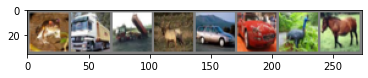

frog  truck truck deer  car   car   bird  horse


In [5]:
# Exploratory Data Analysis

def imshow(img):
    img = img / 2 + 0.5     # unnormalize
    npimg = img.numpy()
    #( M, N, 3): an image with RGB values (0-1 float or 0-255 int)
    plt.imshow(np.transpose(npimg, (1, 2, 0)))
    plt.show()


# get some random training images
images, labels = dataset_X[:8], dataset_Y[:8]
print(images[0].shape)
# show images
imshow(torchvision.utils.make_grid(images))
# print labels
print(' '.join(f'{classes[labels[j]]:5s}' for j in range(8)))



In [6]:
def draw_loss(loss_list, title):
  plt.plot(loss_list)
  plt.title(title)
  plt.xlabel('epoch')
  plt.ylabel('loss')
  last_x = len(loss_list) - 1
  last_y = loss_list[-1]
  plt.text(last_x*0.95, last_y*1.1, f'{last_y:.4}')


In [72]:
# define model (forward propagation)
def ConvBNSiLUMaxPool(in_ch, out_ch):
  return nn.Sequential(
        nn.Conv2d(in_ch, out_ch, 3, 1, 1),
        nn.BatchNorm2d(out_ch),
        nn.SiLU(),
        nn.MaxPool2d(2, 2), # 16
      )

DEVICE = torch.device('cuda:0')
get_model = lambda : nn.Sequential(
    ConvBNSiLUMaxPool(3, 64), # 16
    ConvBNSiLUMaxPool(64, 128), # 8
    ConvBNSiLUMaxPool(128, 256), # 4
    ConvBNSiLUMaxPool(256, 512), # 2
    nn.Conv2d(512, 1024, 2, stride=2, padding=0), # 1
    nn.SiLU(),
    nn.Flatten(),
    nn.Linear(1024, 10), # 10 classes
    nn.Sigmoid()
)
model = get_model()

In [73]:
model

Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (1): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (2): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): SiLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (3): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(512, e

In [76]:
summary(model.to(DEVICE), (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              SiLU-3           [-1, 64, 32, 32]               0
         MaxPool2d-4           [-1, 64, 16, 16]               0
            Conv2d-5          [-1, 128, 16, 16]          73,856
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              SiLU-7          [-1, 128, 16, 16]               0
         MaxPool2d-8            [-1, 128, 8, 8]               0
            Conv2d-9            [-1, 256, 8, 8]         295,168
      BatchNorm2d-10            [-1, 256, 8, 8]             512
             SiLU-11            [-1, 256, 8, 8]               0
        MaxPool2d-12            [-1, 256, 4, 4]               0
           Conv2d-13            [-1, 512, 4, 4]       1,180,160
      BatchNorm2d-14            [-1, 51

In [112]:
# define some useful functions

@torch.no_grad()
def val_acc(m, loss_fn, valloader):
  total_num = 0
  correct_num = 0
  loss_list = []
  m = m.eval()
  for x, y in valloader:
    x = x.to(DEVICE)
    y = y.to(DEVICE)
    y_pred = m(x)
    
    loss = loss_fn(y_pred, y)
    loss_list.append(loss.item())

    y_pred = torch.argmax(y_pred, dim=1)
    correct_num += torch.sum( (y_pred == y)*1 ).item()
    total_num += len(y)

  return correct_num / total_num, sum(loss_list) / len(loss_list)

def train(epoch, m, loss_fn, optimizer, trainloader, valloader=None):
  pbar = tqdm(range(epoch))
  loss_list = []
  val_acc_list = []
  val_acc_v = 0.
  val_loss = 0.
  best_model = copy.deepcopy(m.state_dict())
  best_val_acc = 0.
  best_epoch = 200
  total_time = 0.
  for i in pbar:
    sub_loss_list = []

    m = m.train()
    start = time.time()
    for x, y in trainloader:
      x = x.to(DEVICE)
      y = y.to(DEVICE)
      y_pred = m(x)

      optimizer.zero_grad()
      loss = loss_fn(y_pred, y)
      loss_num = loss.item()
      sub_loss_list.append(loss_num)
      pbar.set_description(f'val_acc={val_acc_v:.4} val_loss={val_loss:.4} loss={loss_num:.4}') 

      loss.backward()
      optimizer.step()

    end = time.time()
    
    total_time =+ (end - start)
    epoch_loss = sum(sub_loss_list) / len(sub_loss_list)
    loss_list.append(epoch_loss)

    if valloader is not None:
      del x; del y # free some GPU memory
      val_acc_v, val_loss = val_acc(m, loss_fn, valloader)
      pbar.set_description(f'val_acc={val_acc_v:.4} val_loss={val_loss:.4} loss={loss_num:.4}') 
      val_acc_list.append(val_acc_v)
      if (i > best_epoch) and (val_acc_v > best_val_acc):
        best_epoch = i
        best_val_acc = val_acc_v
        best_model = copy.deepcopy(m.state_dict())

  print(f'train finished in {total_time}s. Best model at epoch={best_epoch} with val_loss={best_val_acc}')
  m.load_state_dict(best_model)
  return loss_list, val_acc_list

In [102]:
trainloader = DataLoader(trainset, batch_size=3000, shuffle=True)
testloader = DataLoader(testset, batch_size=3500, shuffle=False)

In [103]:
import gc
gc.collect()
torch.cuda.empty_cache()

In [104]:
model = get_model().to(DEVICE)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()
loss_list, val_acc_list = train(300, model, loss_fn, optimizer, trainloader, testloader)

val_acc=0.7144 loss=1.581: 100%|██████████| 300/300 [54:55<00:00, 10.99s/it]

train finished in 10.450820446014404s. Best model at epoch=288 with val_loss=0.7531


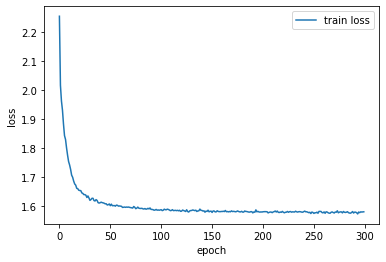

In [106]:
plt.plot(loss_list, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [30]:
!wget https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt

--2022-11-05 21:18:27--  https://raw.githubusercontent.com/pytorch/hub/master/imagenet_classes.txt
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10472 (10K) [text/plain]
Saving to: ‘imagenet_classes.txt’

imagenet_classes.tx 100%[===================>]  10.23K  --.-KB/s    in 0s      

2022-11-05 21:18:27 (77.9 MB/s) - ‘imagenet_classes.txt’ saved [10472/10472]



In [66]:
from torchvision.models import resnet18, ResNet18_Weights

# https://pytorch.org/vision/main/models.html#initializing-pre-trained-models
# New weights with accuracy 80.858%

# tranfer learning
resnet = resnet18(weights=ResNet18_Weights.DEFAULT)
resnet.fc = nn.Linear(512, 10)
resnet = resnet.to(DEVICE)


In [98]:
resnet = resnet.to('cpu')

In [67]:
optimizer2 = optim.Adam(resnet.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
# optimizer2 = optim.SGD(resnet.parameters(), lr=0.02, momentum=0.9, weight_decay=0.001)
loss_fn2 = nn.CrossEntropyLoss()
loss_list2, val_acc_list2 = train(300, resnet, loss_fn2, optimizer2, trainloader, testloader)


val_acc=0.7361 loss=0.229: 100%|██████████| 300/300 [36:08<00:00,  7.23s/it]

train finished in 6.735654830932617s. Best model at epoch=210 with val_loss=0.7175


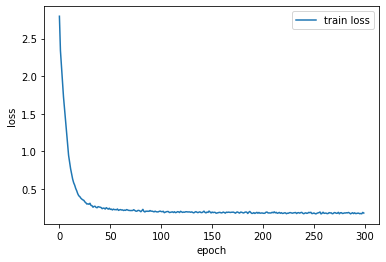

In [81]:
plt.plot(loss_list2, label="train loss")
plt.xlabel("epoch")
plt.ylabel("loss")
plt.legend()

In [60]:
summary(resnet, (3,32,32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 16, 16]           9,408
       BatchNorm2d-2           [-1, 64, 16, 16]             128
              ReLU-3           [-1, 64, 16, 16]               0
         MaxPool2d-4             [-1, 64, 8, 8]               0
            Conv2d-5             [-1, 64, 8, 8]          36,864
       BatchNorm2d-6             [-1, 64, 8, 8]             128
              ReLU-7             [-1, 64, 8, 8]               0
            Conv2d-8             [-1, 64, 8, 8]          36,864
       BatchNorm2d-9             [-1, 64, 8, 8]             128
             ReLU-10             [-1, 64, 8, 8]               0
       BasicBlock-11             [-1, 64, 8, 8]               0
           Conv2d-12             [-1, 64, 8, 8]          36,864
      BatchNorm2d-13             [-1, 64, 8, 8]             128
             ReLU-14             [-1, 6

In [114]:
transform2 = transforms.Compose([
    transforms.RandomResizedCrop(size=(32, 32)),
    transforms.RandomVerticalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
  ])

trainset_raw2 = torchvision.datasets.CIFAR10(root='./data', train=True,
                     download=True, transform=transform2)

testset_raw2 = torchvision.datasets.CIFAR10(root='./data', train=False,
                     download=True, transform=transform)


classes = ('plane', 'car', 'bird', 'cat',
           'deer', 'dog', 'frog', 'horse', 'ship', 'truck')



Files already downloaded and verified
Files already downloaded and verified


In [115]:
model = nn.Sequential(
    ConvBNSiLUMaxPool(3, 64), # 16
    ConvBNSiLUMaxPool(64, 128), # 8
    ConvBNSiLUMaxPool(128, 256), # 4
    ConvBNSiLUMaxPool(256, 512), # 2
    nn.Conv2d(512, 1024, 2, stride=2, padding=0), # 1
    nn.SiLU(),
    nn.Flatten(),
    nn.Linear(1024, 10), # 10 classes
    nn.Sigmoid()
)
model = model.to(DEVICE)

In [ ]:
trainloader = DataLoader(trainset_raw2, batch_size=3000, shuffle=True, num_workers=2)
testloader = DataLoader(testset_raw2, batch_size=3500, shuffle=False, num_workers=2)
optimizer = optim.Adam(model.parameters(), lr=0.01, betas=(0.9,0.9), eps=1e-8, weight_decay=0.001)
loss_fn = nn.CrossEntropyLoss()

loss_list, val_acc_list = train(300, model, loss_fn, optimizer, trainloader, testloader)

val_acc=0.5244 val_loss=1.831 loss=1.841:  90%|█████████ | 450/500 [2:41:34<17:35, 21.11s/it]

# OLD

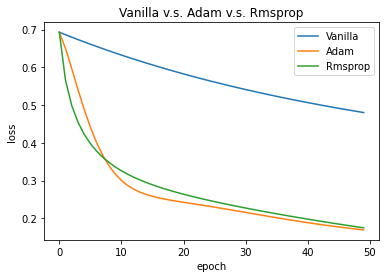

In [ ]:
# compare different algorithm
plt.plot(vanilla_loss_list, label='Vanilla')
plt.plot(adam_loss_list, label='Adam')
plt.plot(rmsprop_loss_list, label='Rmsprop')
plt.title('Vanilla v.s. Adam v.s. Rmsprop')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend()

We used each of Vanilla, Adam, and Rmsprop to train our model for 50 epoches. The Vanilla algorithm reaches an in-sample err of `0.480`; the Adam algorithm achieved an in-sample error of `0.169`; the Rmsprop algorithm had an in-sample error of `0.175`. We should use the advanced optimization algorithm since it gives a boost to our learning speed, and the model will converge faster.

# TEST

preparing data
start training for 500 epoch


loss=0.05902452903341372: 100%|██████████| 500/500 [01:48<00:00,  4.60it/s]


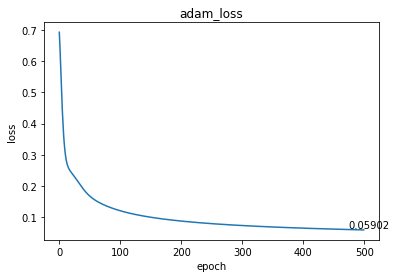

In [ ]:
# Adam
optimizer = Adam(0.001, (0.9, 0.999), 1e-08)
adam_loss_list = train(500, W, B, optimizer)
draw_loss(adam_loss_list, 'adam_loss')